In [ ]:
!pip install gdown grad-cam

In [2]:
import os 
import cv2
import sys
import math
import copy
import timm
import torch
import gdown
import random
import requests
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from skimage import exposure
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torch.distributions.beta import Beta
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
HEIGHT = 224
WEIGHT = 224
BATCH_SIZE = 32

NUM_CLASSES = 44
NUM_CLASSES 

44

In [5]:
test_transforms = transforms.Compose([
    transforms.Resize((HEIGHT, WEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize((0.6078, 0.6078, 0.6078), (0.1932, 0.1932, 0.1932)),
])

In [6]:
def remove_negative(img):
  outside = np.mean(img[ : , 0])
  inside = np.mean(img[ : , int(224 / 2)])
  if outside < inside:
    return img
  else:
    return 1 - img

# lựa chọn tiền xử lý: ảnh gốc, Equalization histogram, CLAHE
def preprocess(img):
    img = remove_negative(img)

    img = exposure.equalize_hist(img)
    img = exposure.equalize_adapthist(img)
    img = exposure.equalize_hist(img)
    return img

def to_gray(image):
    if len(image.shape) == 3 and image.shape[-1] == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
model_multilabel = models.convnext_base(weights='IMAGENET1K_V1')
num_features = model_multilabel.classifier[2].in_features
model_multilabel.classifier[2] = nn.Sequential(
            nn.Linear(num_features, NUM_CLASSES),
            nn.Sigmoid()
        )
model_multilabel.to(device)

In [8]:
!gdown 1y93FtaPp7uqvBbv8gyiJ_1BqOWY7U-sL -O model_multilabel.pt

Downloading...
From (original): https://drive.google.com/uc?id=1y93FtaPp7uqvBbv8gyiJ_1BqOWY7U-sL
From (redirected): https://drive.google.com/uc?id=1y93FtaPp7uqvBbv8gyiJ_1BqOWY7U-sL&confirm=t&uuid=172dc73b-6480-42bf-ba1f-9002a6ffba36
To: /kaggle/working/model_multilabel.pt
100%|█████████████████████████████████████████| 351M/351M [00:02<00:00, 141MB/s]


In [9]:
model_multilabel.load_state_dict(torch.load('/kaggle/working/model_multilabel.pt'))

<All keys matched successfully>

In [ ]:
model_baseline = models.convnext_base(weights='IMAGENET1K_V1')
num_features = model_baseline.classifier[2].in_features
model_baseline.classifier[2] = nn.Sequential(
            nn.Linear(num_features, 5),
            nn.Sigmoid()
        )
model_baseline.to(device)

In [11]:
!gdown 1L8aXtzoS27zLGmxklISjZqrrEAB-48_i -O model_baseline.pt

Downloading...
From (original): https://drive.google.com/uc?id=1L8aXtzoS27zLGmxklISjZqrrEAB-48_i
From (redirected): https://drive.google.com/uc?id=1L8aXtzoS27zLGmxklISjZqrrEAB-48_i&confirm=t&uuid=1bb892ca-7871-4015-9f70-039b1f19e1fd
To: /kaggle/working/model_baseline.pt
100%|████████████████████████████████████████| 350M/350M [00:06<00:00, 51.3MB/s]


In [12]:
model_baseline.load_state_dict(torch.load('/kaggle/working/model_baseline.pt'))

<All keys matched successfully>

In [58]:
image_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/4/9422381R.png"
true_class = 4

In [59]:
cv2_image = cv2.imread(image_path)
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(cv2_image)

In [60]:
transformed_image = test_transforms(image)
input_tensor = transformed_image.unsqueeze(0).to(device)

numpy_image = np.array(image) / 225

In [61]:
target_layers = [model_multilabel.features[-1]]  # Chọn lớp cuối cùng của ConvNeXt
cam_multilabel = GradCAM(model=model_multilabel, target_layers=target_layers)

target_layers = [model_baseline.features[-1]]  # Chọn lớp cuối cùng của ConvNeXt
cam_baseline = GradCAM(model=model_baseline, target_layers=target_layers)

In [62]:
targets = [ClassifierOutputTarget(true_class)]
grayscale_cam_multilabel = cam_multilabel(input_tensor=input_tensor, targets=targets)[0, :]

grayscale_cam_baseline = cam_baseline(input_tensor=input_tensor, targets=targets)[0, :]

In [63]:
predicted_multilabel = np.argmax(cam_multilabel.outputs.detach().cpu().numpy()[0,:5])
predicted_baseline = np.argmax(cam_baseline.outputs.detach().cpu().numpy()[0,:5])
print("baseline pred class: ",predicted_baseline)
print("multilabel pred class: ",predicted_multilabel)
print("true class: ",true_class)

baseline pred class:  3
multilabel pred class:  4
true class:  4


In [64]:
cam_multilabel.outputs.detach().cpu().numpy()

array([[0.02262656, 0.00713417, 0.00517196, 0.08932859, 0.86478907,
        0.9713399 , 0.01373453, 0.02133213, 0.01576247, 0.02265924,
        0.02181858, 0.97098845, 0.5725364 , 0.09901354, 0.06521703,
        0.18544762, 0.99620795, 0.00499973, 0.00319406, 0.0041345 ,
        0.01835113, 0.04115007, 0.33625323, 0.6538228 , 0.01481185,
        0.02645848, 0.615297  , 0.43105492, 0.0135442 , 0.02588474,
        0.12873264, 0.8701529 , 0.01331499, 0.02563057, 0.63818234,
        0.29649705, 0.78583443, 0.16114159, 0.02709197, 0.02338181,
        0.9960211 , 0.00212565, 0.00332758, 0.00485943]], dtype=float32)

In [65]:
cam_baseline.outputs.detach().cpu().numpy()

array([[0.00565458, 0.00129365, 0.00077195, 0.6115316 , 0.39449775]],
      dtype=float32)

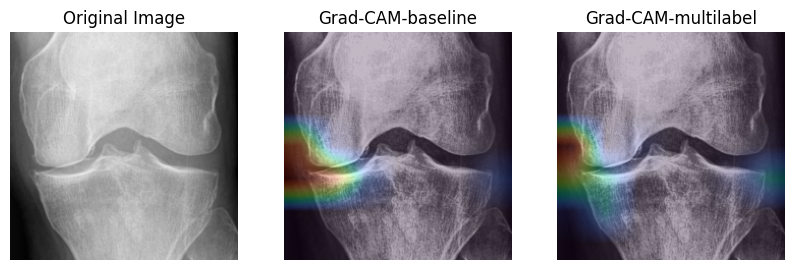

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title(f'Original Image-{true_class}')

axs[1].imshow(preprocess(to_gray(cv2_image)), cmap="gray")
axs[1].imshow(grayscale_cam_baseline, cmap="turbo", alpha=0.3)
axs[1].axis('off')
axs[1].set_title(f'baseline-{predicted_baseline}')

axs[2].imshow(preprocess(to_gray(cv2_image)), cmap="gray")
axs[2].imshow(grayscale_cam_multilabel, cmap="turbo", alpha=0.3)
axs[2].axis('off')
axs[2].set_title(f'multilabel-{predicted_multilabel}')

plt.show()



In [30]:
!rm -rf /kaggle/working/compare_gradcam

In [31]:
subsets = ["val", "test"]
levels = ["0", "1", "2", "3", "4"]
root = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
out = "compare_gradcam"

In [32]:
for subset in subsets:
    subset_path = os.path.join(root, subset)
    for level in levels:
        print(f"-----------------processing for {subset}-{level}---------------")
        level_path = os.path.join(subset_path, level)
        out_path = os.path.join(out, subset, level)
        os.makedirs(out_path, exist_ok=True)
        for image_name in os.listdir(level_path):
            image_path = os.path.join(level_path, image_name)
            cv2_image = cv2.imread(image_path)
            cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(cv2_image)
            
            true_class = int(level)
            
            transformed_image = test_transforms(image)
            input_tensor = transformed_image.unsqueeze(0).to(device)

            numpy_image = np.array(image) / 225
            
            targets = [ClassifierOutputTarget(true_class)]
            grayscale_cam_multilabel = cam_multilabel(input_tensor=input_tensor, targets=targets)[0, :]
            grayscale_cam_baseline = cam_baseline(input_tensor=input_tensor, targets=targets)[0, :]
            
            predicted_multilabel = np.argmax(cam_multilabel.outputs.detach().cpu().numpy()[0,:5])
            predicted_baseline = np.argmax(cam_baseline.outputs.detach().cpu().numpy()[0,:5])
            
            if predicted_multilabel == true_class and predicted_baseline != true_class:
                print(image_name)
                fig, axs = plt.subplots(1, 3, figsize=(10, 5))
                axs[0].imshow(image)
                axs[0].axis('off')
                axs[0].set_title(f'Original Image-{true_class}')

                axs[1].imshow(preprocess(to_gray(cv2_image)), cmap="gray")
                axs[1].imshow(grayscale_cam_baseline, cmap="turbo", alpha=0.3)
                axs[1].axis('off')
                axs[1].set_title(f'baseline-{predicted_baseline}')

                axs[2].imshow(preprocess(to_gray(cv2_image)), cmap="gray")
                axs[2].imshow(grayscale_cam_multilabel, cmap="turbo", alpha=0.3)
                axs[2].axis('off')
                axs[2].set_title(f'multilabel-{predicted_multilabel}')

                plt.savefig(os.path.join(out_path, image_name), bbox_inches='tight', dpi=300)
                plt.close(fig)

-----------------processing for val-0---------------
9455113L.png
9107980L.png
9129226L.png
9137393L.png
9195845L.png
9658663L.png
9104620L.png
9661713L.png
9999295L.png
9305065L.png
9775753L.png
9063934R.png
9804376L.png
9642569L.png
9194860L.png
9015402L.png
9244537R.png
9691423R.png
-----------------processing for val-1---------------
9092643R.png
9244535R.png
9962232L.png
9031961R.png
9679795R.png
9643665R.png
9909903R.png
9991580R.png
9369225R.png
9244537L.png
9928272L.png
9835061R.png
9868067R.png
9752895R.png
9548401L.png
9181583R.png
9019907R.png
9807689R.png
9548401R.png
9275309R.png
-----------------processing for val-2---------------
9736012L.png
9362978L.png
9274364R.png
9686327R.png
9637958L.png
9466438L.png
9922855L.png
9997869R.png
9461619L.png
9031141R.png
9350339L.png
9429147R.png
9118689L.png
9461619R.png
9866738L.png
9112020L.png
9607739L.png
9906998L.png
9122517R.png
9455113R.png
9112020R.png
9680344L.png
9466438R.png
9938327L.png
9746075R.png
9320093R.png
9724015R.

In [35]:
!zip -r compare_gradcam.zip compare_gradcam

  adding: compare_gradcam/ (stored 0%)
  adding: compare_gradcam/val/ (stored 0%)
  adding: compare_gradcam/val/3/ (stored 0%)
  adding: compare_gradcam/val/3/9620647R.png (deflated 7%)
  adding: compare_gradcam/val/3/9115049R.png (deflated 6%)
  adding: compare_gradcam/val/3/9275159R.png (deflated 7%)
  adding: compare_gradcam/val/3/9919023R.png (deflated 8%)
  adding: compare_gradcam/val/3/9206535R.png (deflated 7%)
  adding: compare_gradcam/val/3/9926602R.png (deflated 7%)
  adding: compare_gradcam/val/3/9437407L.png (deflated 6%)
  adding: compare_gradcam/val/3/9792327L.png (deflated 6%)
  adding: compare_gradcam/val/3/9792327R.png (deflated 6%)
  adding: compare_gradcam/val/3/9947240R.png (deflated 6%)
  adding: compare_gradcam/val/3/9055512L.png (deflated 7%)
  adding: compare_gradcam/val/3/9102858R.png (deflated 7%)
  adding: compare_gradcam/val/3/9690400R.png (deflated 7%)
  adding: compare_gradcam/val/2/ (stored 0%)
  adding: compare_gradcam/val/2/9461619L.png (deflated 6%)
  